In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from numpy import exp
from scipy import ndimage
import random

In [2]:
z = 0.043143
k = z+1
print(z*300000.0)
k

12942.9


1.043143

In [3]:
5000.84/k,5005.04/k #To exclude the sharp peak for our subcube / width of the subcube

(4794.011942753775, 4798.03823636836)

In [4]:
hdu = fits.open('HE0232-0900.wo_absorption.fits')
qso_data = hdu[0].data
qso_error = hdu[1].data
qso_header = hdu[0].header
wavestart = qso_header['CRVAL3']
wavint = qso_header['CD3_3']
wave = wavestart+np.arange(qso_data.shape[0])*wavint

In [5]:
mini_cube = qso_data[:,47:56,63:72]
mini_cube_err = qso_error[:,47:56,63:72]

In [6]:
qso_header['CRPIX1'] = qso_header['CRPIX1'] - 63
qso_header['CRPIX2'] = qso_header['CRPIX2'] - 47
new_hdu = fits.PrimaryHDU(data=mini_cube,header=qso_header)

s = 'minicube_0900.fits'
x = random.randint(1,101)
s = str(x) + s
print("Filename: "+str(s))
new_hdu.writeto(s,overwrite=True)

Filename: 77minicube_0900.fits


In [8]:
hdu = fits.open(s)
mini_data = mini_cube
mini_data_err = mini_cube_err
mini_header = hdu[0].header

In [9]:
from profile_fitting_HE0232_0900 import redshift,line_width,gauss,Hb_O3_gauss,Fe_doublet_gauss,Hb_Fe_doublet_gauss,full_gauss2,fixed_parameters,full_gauss2_fixkin

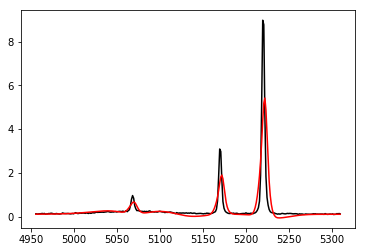

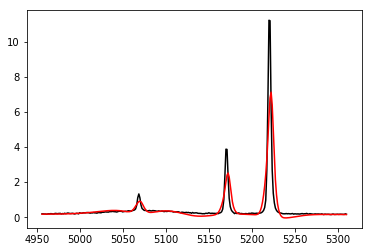

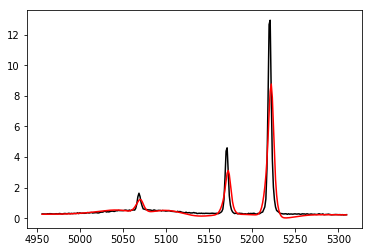

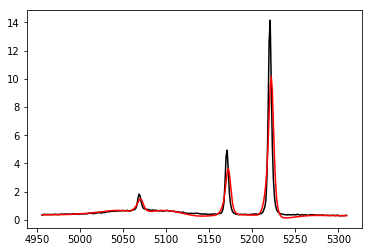

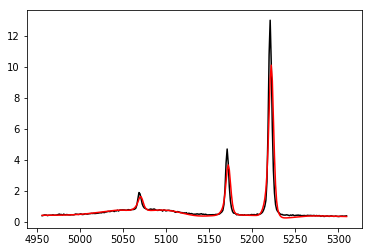

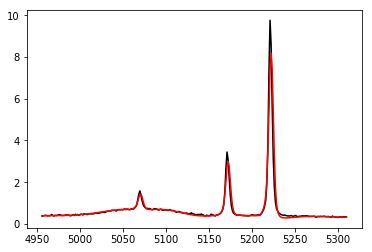

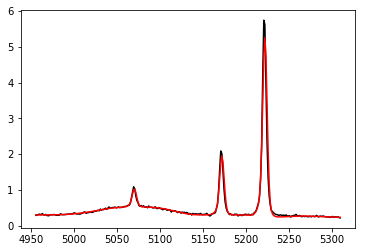

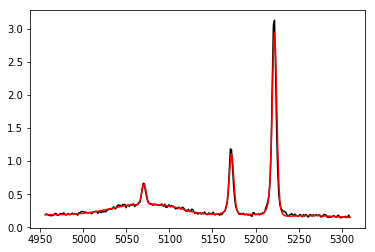

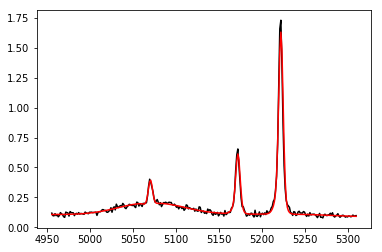

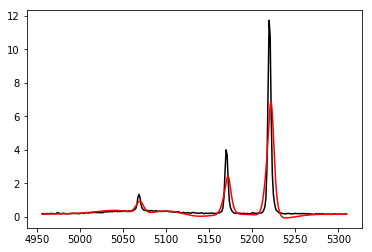

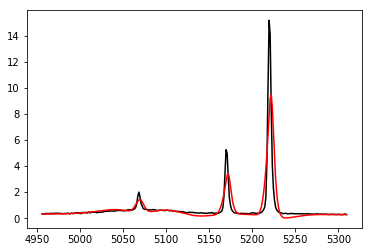

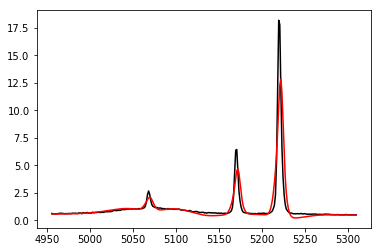

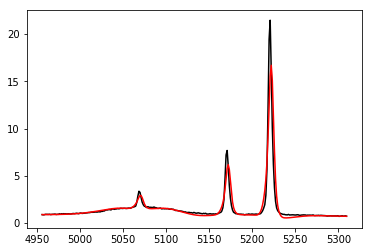

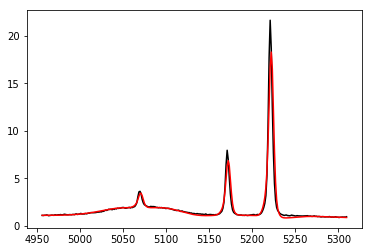

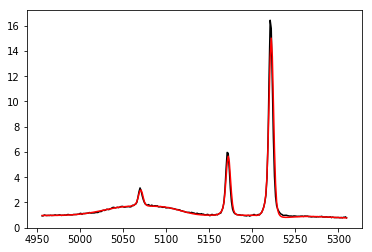

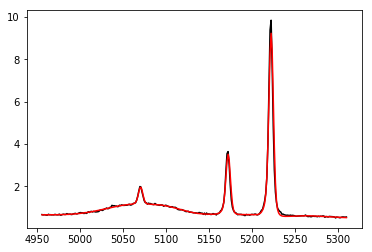

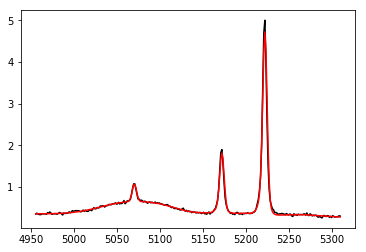

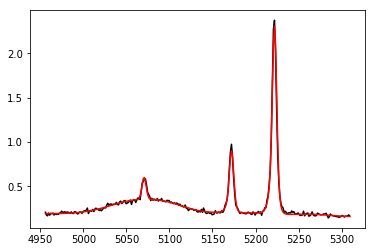

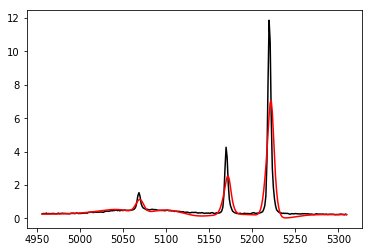

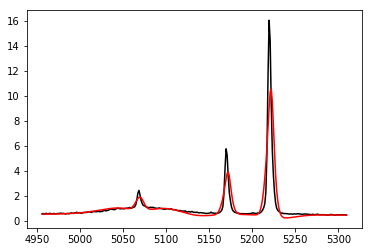

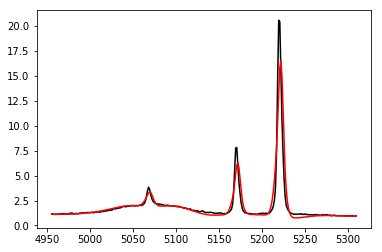

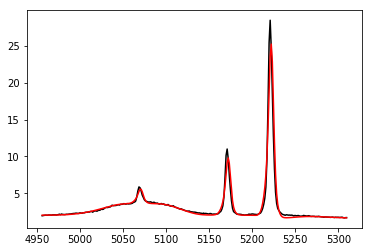

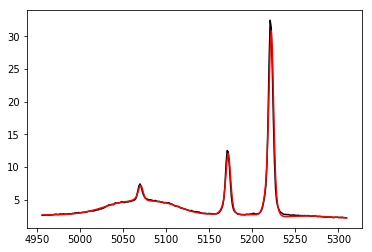

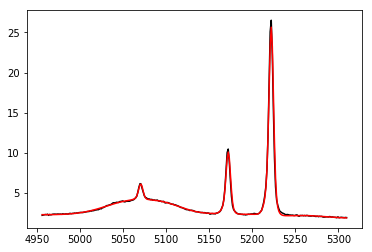

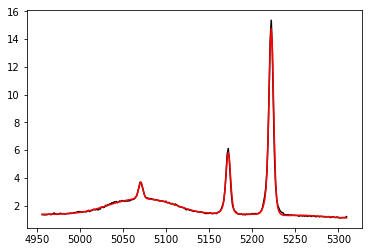

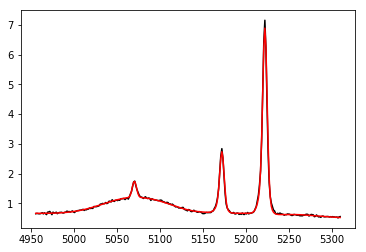

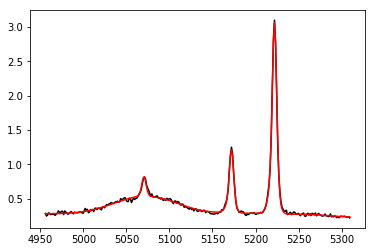

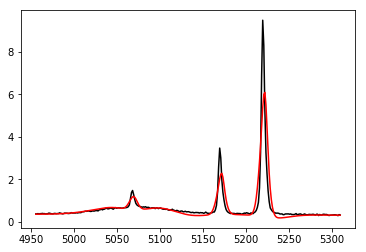

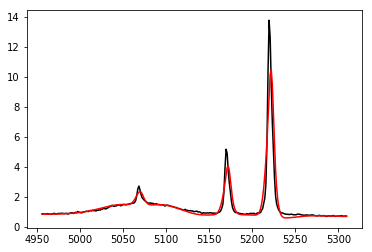

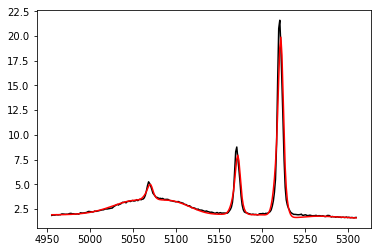

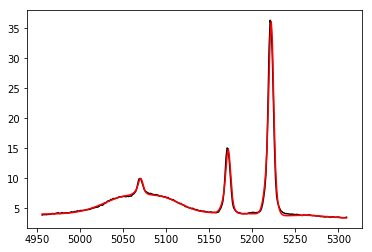

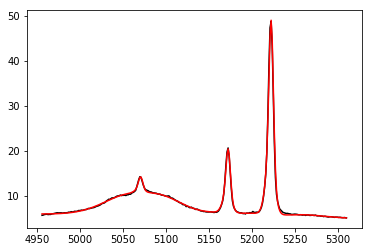

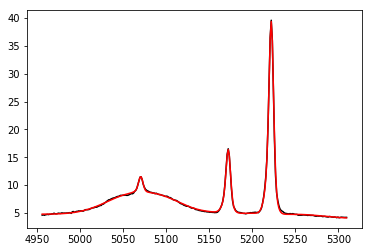

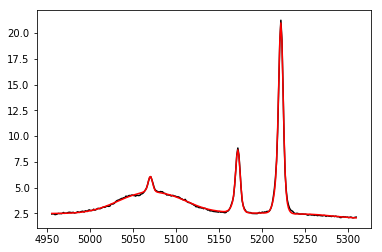

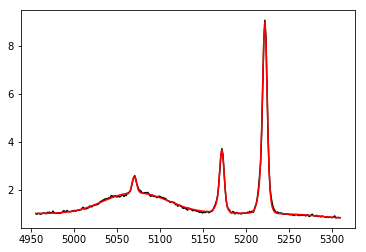

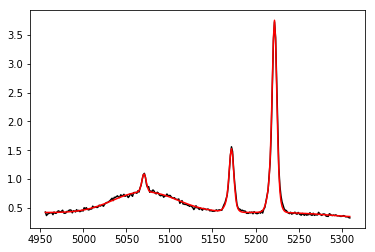

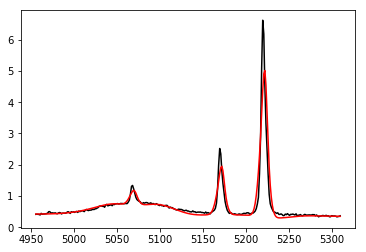

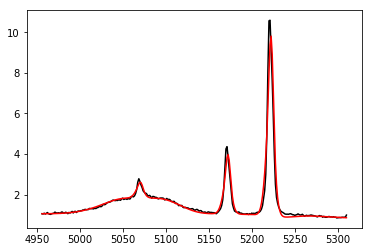

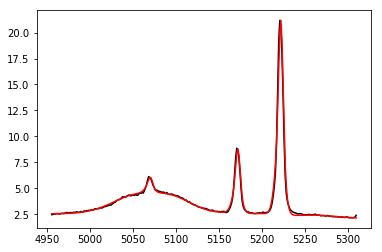

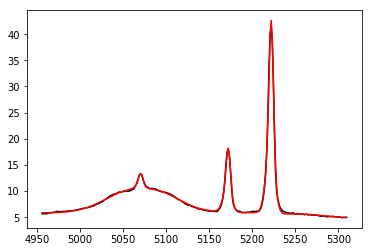

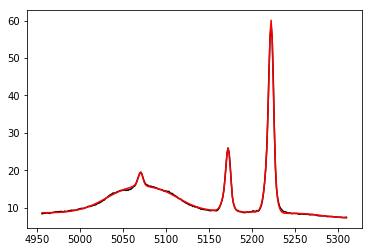

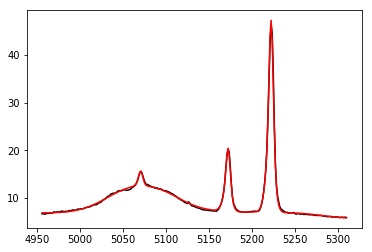

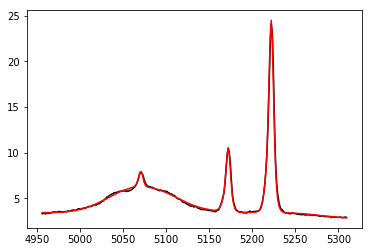

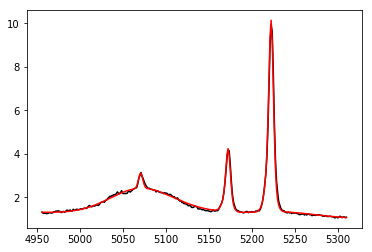

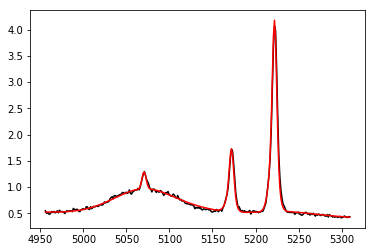

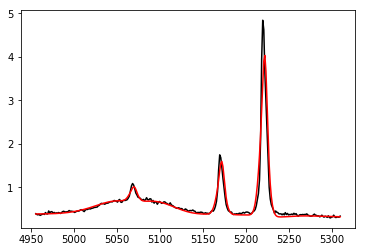

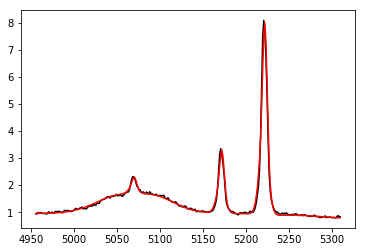

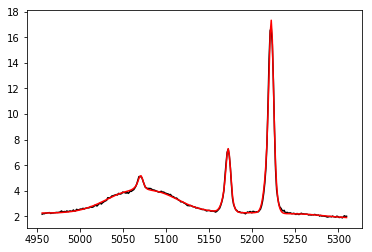

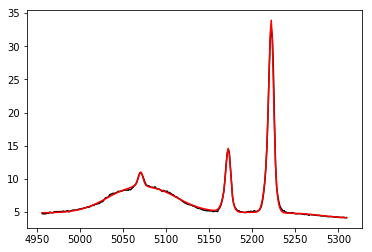

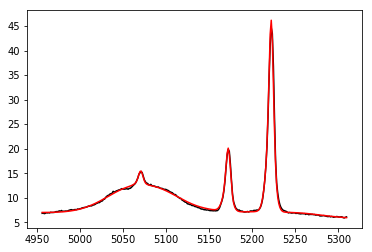

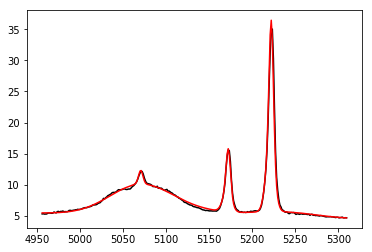

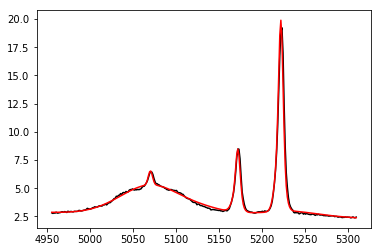

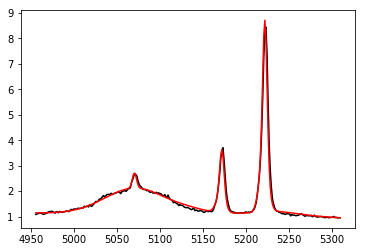

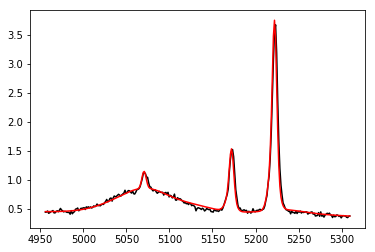

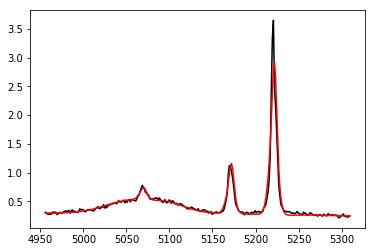

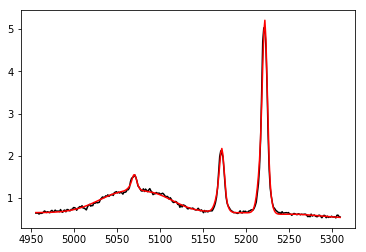

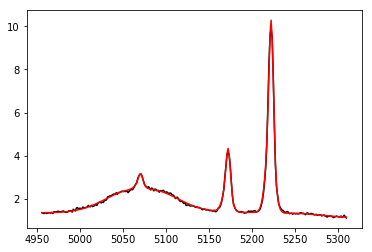

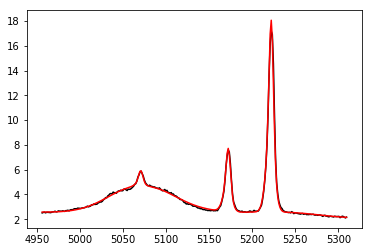

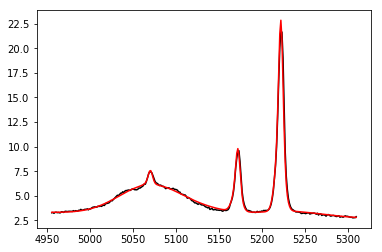

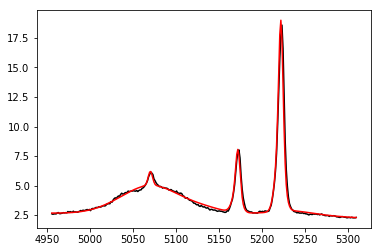

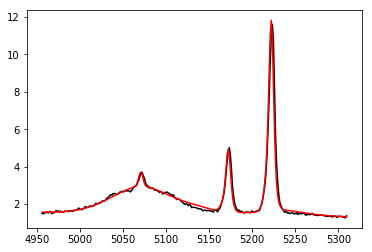

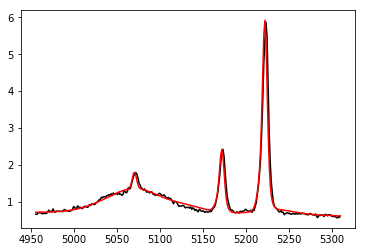

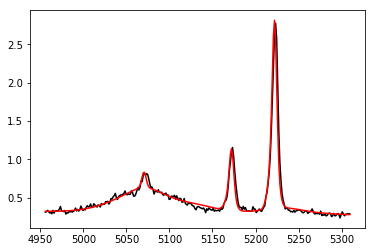

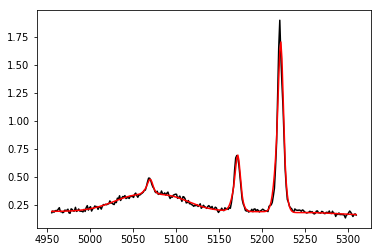

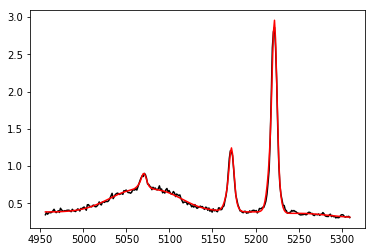

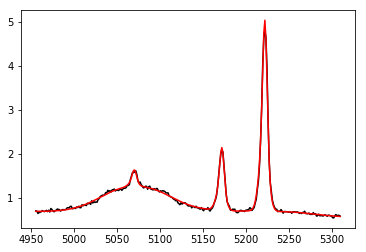

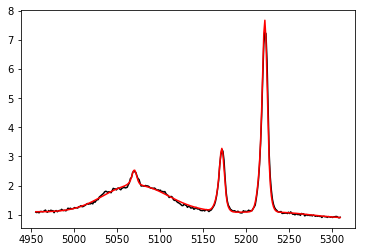

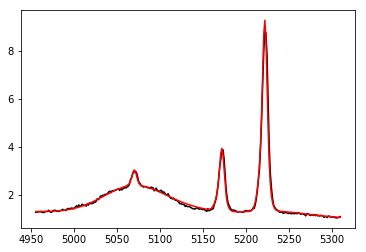

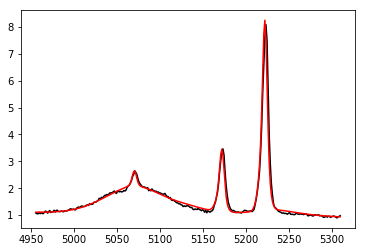

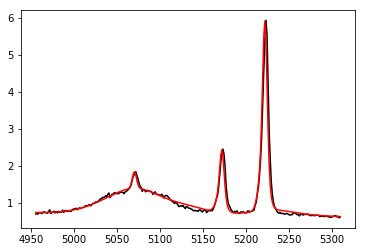

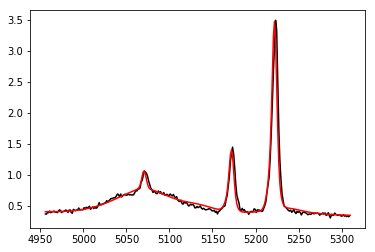

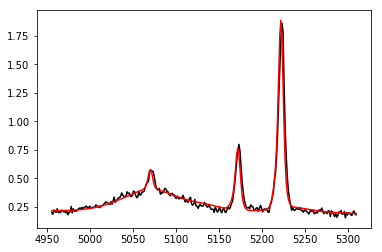

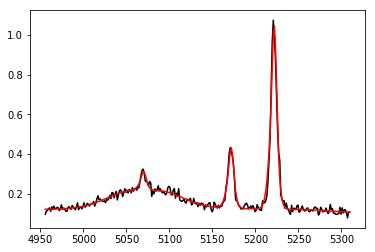

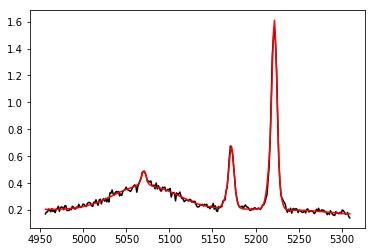

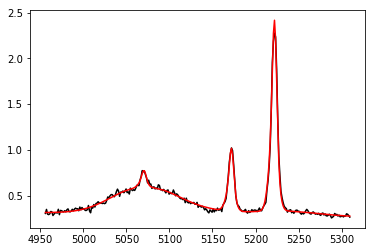

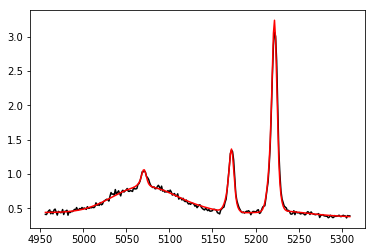

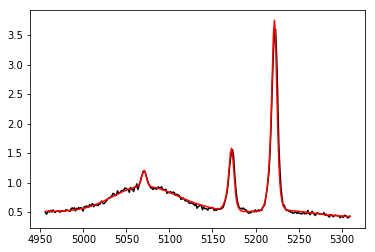

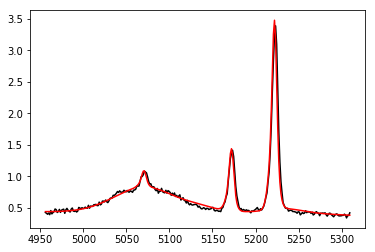

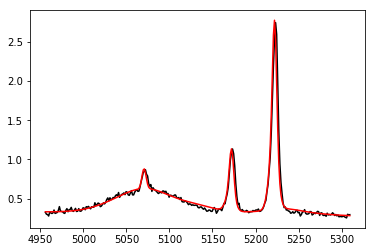

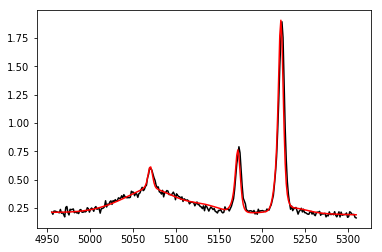

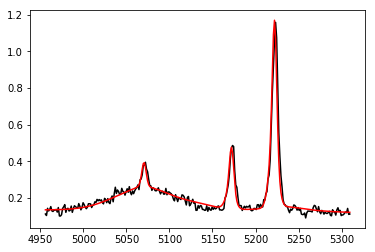

In [10]:
output_par = np.zeros((10,mini_data.shape[1],mini_data.shape[1]))
output_par_err = np.zeros((10,mini_data.shape[1],mini_data.shape[1]))
coordinate_output_par = np.zeros((2,mini_data.shape[1],mini_data.shape[1]))
for i in range(mini_data.shape[1]):
    for j in range(mini_data.shape[2]):
        spectrum = mini_data[:,i,j]
        error =  mini_data_err[:,i,j]
        select = (wave>4750*k) & (wave<5090*k)
        popt_spec2,pcov_spec2 = curve_fit(full_gauss2_fixkin,wave[select],spectrum[select], p0=[1,1,1,1,1,1,1,1,-0.001,1])
        plt.plot(wave[select],spectrum[select],'k-')
        plt.plot(wave[select],full_gauss2_fixkin(wave[select],*popt_spec2),'r-',label='fit')
        plt.show()
        output_par[:,i,j]=popt_spec2
        noise_data = np.random.normal(spectrum,error)
        popt_spec_error,pcov_spec_error = curve_fit(full_gauss2_fixkin,wave[select],noise_data[select],p0=[1,1,1,1,1,1,1,1,-0.001,1])                                                    
        Monte_Carlo_loops = 10
        spec_parameters_MC = np.zeros((len(popt_spec_error),Monte_Carlo_loops))
        for l in range(Monte_Carlo_loops):
                iteration_data = np.random.normal(spectrum[select],error[select]) # modify the data every loop again within the error 
                popt_spec_MC,pcov_spec_MC = curve_fit(full_gauss2_fixkin,wave[select],iteration_data,sigma=error[select],p0 = popt_spec2, maxfev = 1000000)
                spec_parameters_MC[:,l]=popt_spec_MC
        spec_parameters_err= np.std(spec_parameters_MC,1)
        (amp_Hb_error,amp_OIII5007_error,amp_OIII5007_br_error,amp_Hb_br_error,amp_Hb1_error,amp_Hb2_error,amp_Fe5018_1_error,amp_Fe5018_2_error,m_error,c_error) = spec_parameters_err
        output_par_err[:,i,j] = spec_parameters_err
        coordinate_output_par[:,i,j] = (i+154,j+149) 
hdus=[]
#amp_Hb,amp_OIII5007,amp_OIII5007_br,amp_Hb_br,amp_Hb1,amp_Hb2,amp_Fe5018_1,amp_Fe5018_2,m,c
hdus.append(fits.PrimaryHDU())
hdus.append(fits.ImageHDU(output_par[0,:,:],name='amp_Hb'))
hdus.append(fits.ImageHDU(output_par[1,:,:],name='amp_OIII5007'))
hdus.append(fits.ImageHDU(output_par[2,:,:],name='amp_OIII5007_br'))
hdus.append(fits.ImageHDU(output_par[3,:,:],name='amp_Hb_br'))
hdus.append(fits.ImageHDU(output_par[4,:,:],name='amp_Hb1'))
hdus.append(fits.ImageHDU(output_par[5,:,:],name='amp_Hb2'))
hdus.append(fits.ImageHDU(output_par[6,:,:],name='amp_Fe5018_1'))
hdus.append(fits.ImageHDU(output_par[7,:,:],name='amp_Fe5018_2'))
hdus.append(fits.ImageHDU(output_par[8,:,:],name='m'))
hdus.append(fits.ImageHDU(output_par[9,:,:],name='c'))
hdu = fits.HDUList(hdus)
hdu.writeto('subcube_par_HE0232-0900.fits',overwrite='True')

In [11]:
hdus=[]
#amp_Hb,amp_OIII5007,amp_OIII5007_br,amp_Hb_br,amp_Hb1,amp_Hb2,amp_Fe5018_1,amp_Fe5018_2,m,c
hdus.append(fits.PrimaryHDU())
hdus.append(fits.ImageHDU(output_par_err[0,:,:],name='amp_Hb_err'))
hdus.append(fits.ImageHDU(output_par_err[1,:,:],name='amp_OIII5007_err'))
hdus.append(fits.ImageHDU(output_par_err[2,:,:],name='amp_OIII5007_br_err'))
hdus.append(fits.ImageHDU(output_par_err[3,:,:],name='amp_Hb_br_err'))
hdus.append(fits.ImageHDU(output_par_err[4,:,:],name='amp_Hb1_err'))
hdus.append(fits.ImageHDU(output_par_err[5,:,:],name='amp_Hb2_err'))
hdus.append(fits.ImageHDU(output_par_err[6,:,:],name='amp_Fe5018_1_err'))
hdus.append(fits.ImageHDU(output_par_err[7,:,:],name='amp_Fe5018_2_err'))
hdus.append(fits.ImageHDU(output_par_err[8,:,:],name='m_err'))
hdus.append(fits.ImageHDU(output_par_err[9,:,:],name='c_err'))
hdu = fits.HDUList(hdus)
hdu.writeto('subcube_par_err_HE0232-0900.fits',overwrite='True')

In [12]:
hdu = fits.open('subcube_par_HE0232-0900.fits')
OIII_br_data = hdu[3].data
Hb1_br_data = hdu[5].data
centroid_OIII_br = ndimage.measurements.center_of_mass(OIII_br_data)
centroid_Hb1_br = ndimage.measurements.center_of_mass(Hb1_br_data)
print('centroid_OIII_br is', centroid_OIII_br)
print('centroid_Hb1_br is ', centroid_Hb1_br)

centroid_OIII_br is (3.6123512327059744, 3.4064019719744154)
centroid_Hb1_br is  (3.9636930725315715, 3.9628557544295639)


In [13]:
outflow_size_arcsec = 0.4*(np.sqrt(((centroid_OIII_br[0])- (centroid_Hb1_br[0]))**2 + ((centroid_OIII_br[1])- (centroid_Hb1_br[1]))**2))
print(outflow_size_arcsec)

0.263235833555


In [14]:
# angular distance D_a = 175.5 Mpc and 1 arcsec = 4.848 micro radian
outflow_size_parsec = 175.5*4.848*(outflow_size_arcsec) #It has the unit of parsecs
print(outflow_size_parsec)

223.967364848
